In [1]:
from audio import AudioDataset, AudioFile

In [2]:
# Load guitar audio
test = AudioDataset('../data/raw/nsynth-test')
guitar = AudioFile(*test.get_filepath('guitar_acoustic', 6))
guitar.fundamental_freq = 110  # A2
# Load piano audio
train = AudioDataset('../data/raw/nsynth-train')
piano = AudioFile(*train.get_filepath('keyboard_acoustic', 27))
piano.fundamental_freq = 55  # A1

In [3]:
# Functions
def boxprint(s):
    """Print string surrounded by lines"""
    l = '-' * len(s)
    print(f'{l}\n{s}\n{l}')

# 1. Spectrogram analysis<a id='spectrogram'></a>

The nylon guitar tone:
- Is composed of harmonic sine waves with decaying amplitude
- Has additional energy in the frequency band below the fundamental frequency (see [section 2](#filter)). These lower frequencies don't have any harmonics themselves.

The grand piano tone:
- Is composed of harmonic sine waves, as well as many powerful non-harmonic frequencies

- Has more energy around the 3rd and 4th harmonics than the fundamental (see [section 2](#filter)). These higher frequencies don't have any harmonics themselves.

## Guitar

--------------
Guitar attack:
--------------


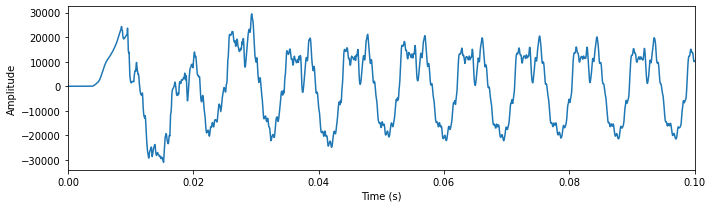

- original sound:


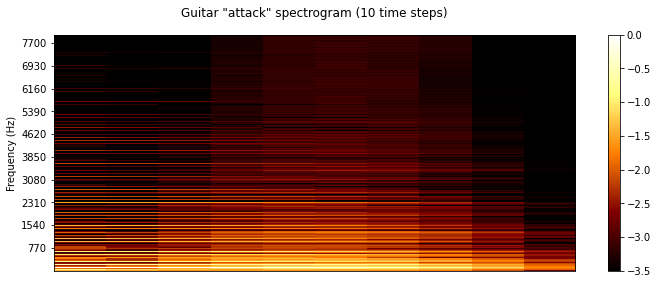

- reconstructed sound:


---------------
Guitar sustain:
---------------


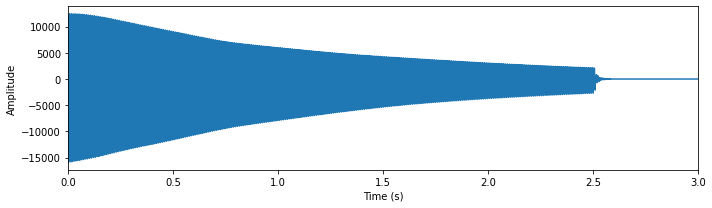

- original sound:


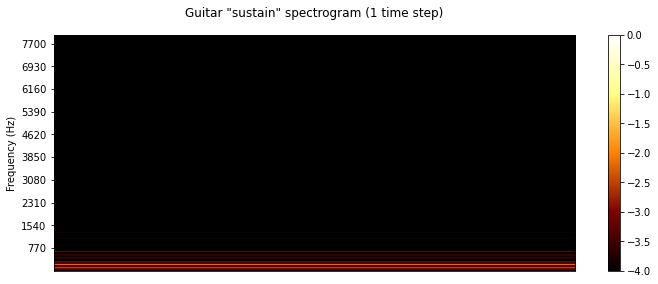

- reconstructed sound:


In [4]:
# Guitar
params = [
    {'start': 0, 'end': 0.1, 'time_intervals': 10, 'spec_thresh': 3.5, 'max_freq': -1,
     'print': 'Guitar attack:', 'title': 'Guitar "attack" spectrogram (10 time steps)'},
    {'start': 0.5, 'end': 3.5, 'time_intervals': 1, 'spec_thresh': 4, 'max_freq': -1,
     'print': 'Guitar sustain:', 'title': 'Guitar "sustain" spectrogram (1 time step)'}
]
for p in params:
    boxprint(p['print'])
    # Load and play audio
    guitar.trim_audio(p['start'], p['end'])
    guitar.plot_audio()
    print('- original sound:')
    guitar.play_audio()
    # Create spectrogram and reconstruct audio
    guitar.audio_to_spectrogram(p['time_intervals'], p['spec_thresh'])
    guitar.plot_spectrogram(guitar.spectrogram, max_freq=p['max_freq'],
                            title=p['title'], figsize=(10, 4))
    print('- reconstructed sound:')
    guitar.spectrogram_to_audio(guitar.spectrogram)

## Piano

-------------
Piano attack:
-------------


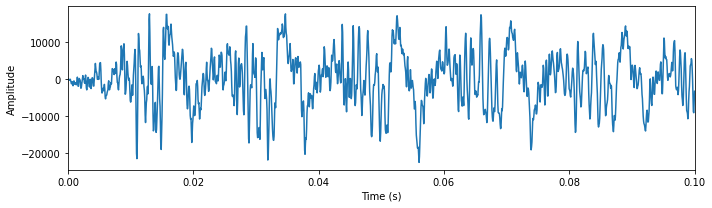

- original sound:


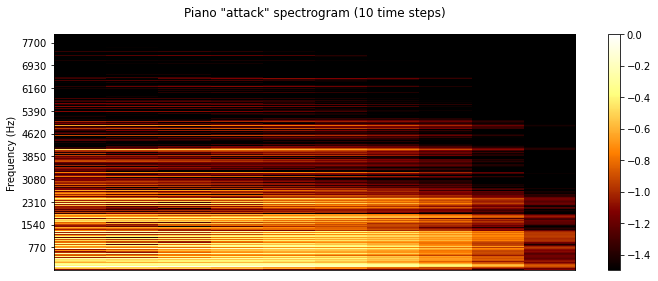

- reconstructed sound:


--------------
Piano sustain:
--------------


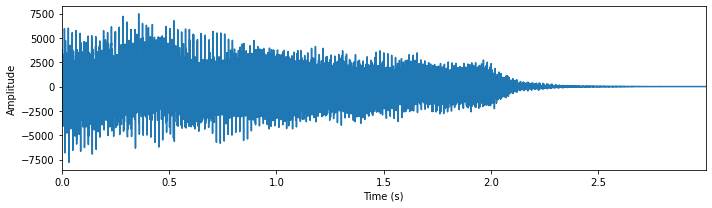

- original sound:


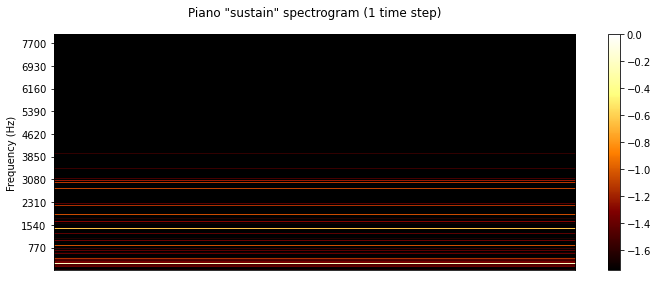

- reconstructed sound:


In [5]:
# Piano
params = [
    {'start': 0, 'end': 0.1, 'time_intervals': 10, 'spec_thresh': 3, 'max_freq': -1,
     'print': 'Piano attack:', 'title': 'Piano "attack" spectrogram (10 time steps)'},
    {'start': 1, 'end': -1, 'time_intervals': 1, 'spec_thresh': 3.5, 'max_freq': -1,
     'print': 'Piano sustain:', 'title': 'Piano "sustain" spectrogram (1 time step)'}
]
for p in params:
    # Print
    boxprint(p['print'])
    # Load and play audio
    piano.trim_audio(p['start'], p['end'])
    piano.plot_audio()
    print('- original sound:')
    piano.play_audio()
    # Create spectrogram and reconstruct audio
    piano.audio_to_spectrogram(p['time_intervals'], p['spec_thresh'])
    piano.plot_spectrogram(piano.spectrogram/2, max_freq=p['max_freq'],
                           title=p['title'], figsize=(10, 4))
    print('- reconstructed sound:')
    piano.spectrogram_to_audio(piano.spectrogram)

# 2. Post-filter analysis<a id='filter'></a>

After applying a lowpass filter which removes frequencies above the 2nd harmonic:

- The guitar sounds roughly the same (just a lowpass version)
- The piano sounds very different (almost like the guitar now)


This shows that:

- The guitar tone has a lot of energy in its lower harmonics
- The piano tone has a lot of energy in its upper harmonics

## Guitar

No filter:


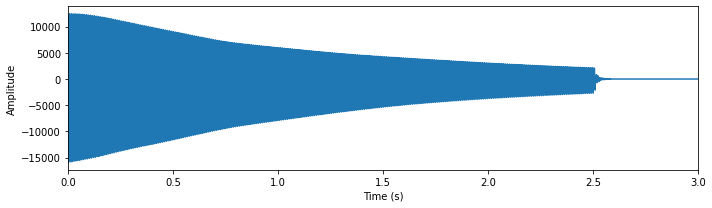

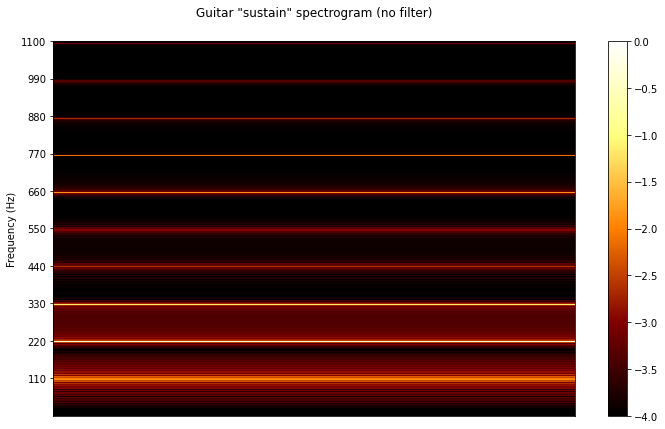

Low-pass filter:


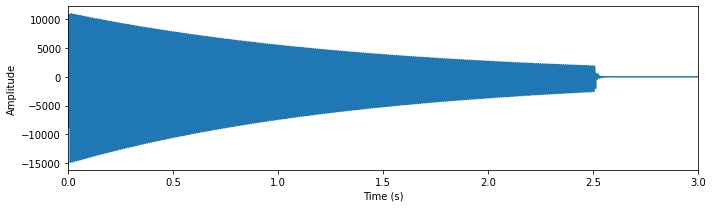

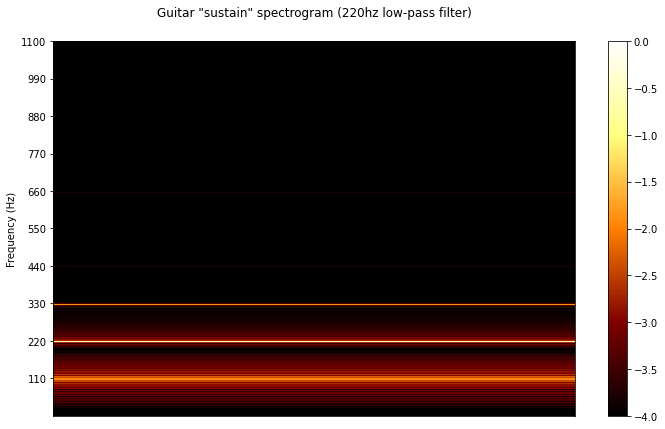

In [6]:
guitar.trim_audio(start=0.5, end=3.5)

print('No filter:')
# Load and play audio
guitar.plot_audio()
guitar.play_audio()
# Create spectrogram
guitar.audio_to_spectrogram(spec_thresh=4)
guitar.plot_spectrogram(guitar.spectrogram, 'Guitar "sustain" spectrogram (no filter)')

print('Low-pass filter:')
# Load and play audio - with lowpass filter
guitar.filter_audio(0, 2*guitar.fundamental_freq, 'lowpass')
guitar.plot_audio()
guitar.play_audio()
# Create spectrogram
guitar.audio_to_spectrogram(spec_thresh=4)
guitar.plot_spectrogram(guitar.spectrogram, 'Guitar "sustain" spectrogram (220hz low-pass filter)')

## Piano

No filter


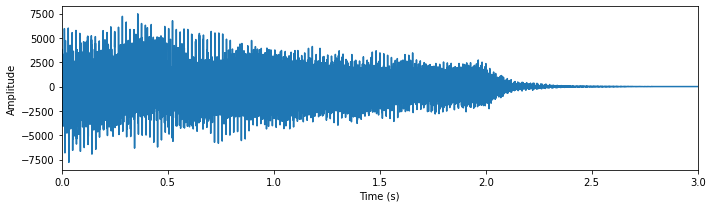

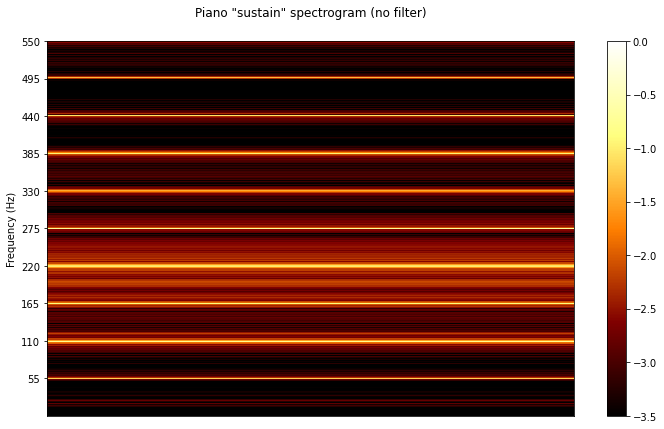

Low-pass filter:


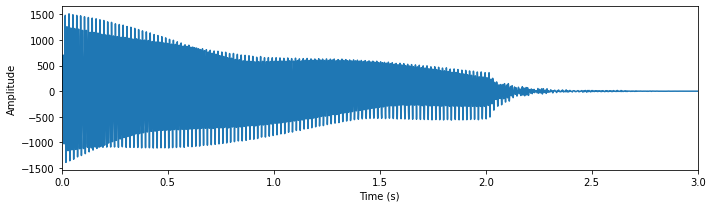

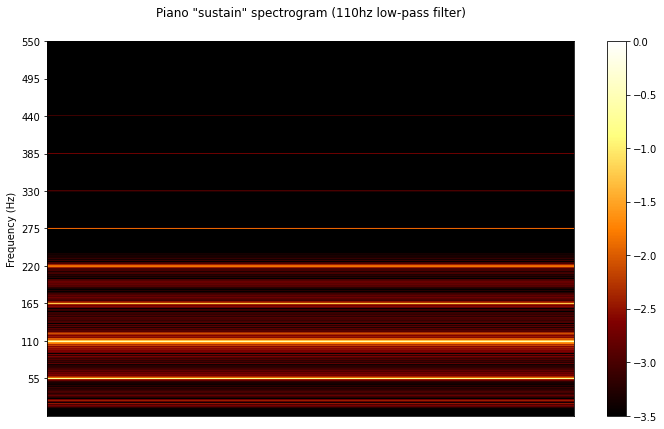

In [7]:
piano.trim_audio(start=1, end=4)

print('No filter')
# Load and play audio
piano.plot_audio()
piano.play_audio()
# Create spectrogram
piano.audio_to_spectrogram(spec_thresh=3.5)
piano.plot_spectrogram(piano.spectrogram, 'Piano "sustain" spectrogram (no filter)')

print('Low-pass filter:')
# Load and play audio - with lowpass filter
piano.filter_audio(0, 2*piano.fundamental_freq, 'lowpass')
piano.plot_audio()
piano.play_audio()
# Create spectrogram
piano.audio_to_spectrogram(spec_thresh=3.5)
piano.plot_spectrogram(piano.spectrogram, 'Piano "sustain" spectrogram (110hz low-pass filter)')

# 3. Harmonics analysis<a id='harmonics'></a>

Removing all frequencies except the harmonics of the fundamental frequency:

- The guitar sounds roughly the same (just a bit more like a pure sine-wave oscillator)
- The piano sounds very different (kind of like a chime or square wave)


This shows that:

- The guitar tone has a lot of energy in the harmonics themselves
- The piano tone has a lot of energy in the frequencies around its harmonics

N.B. Setting the same amplitude to all of the harmonics (0dB - maximum) sounds like a sawtooth wave. This demonstrates that the relative amplitudes of the harmonics has an important role in determining the final sound.

## Guitar

All frequencies:


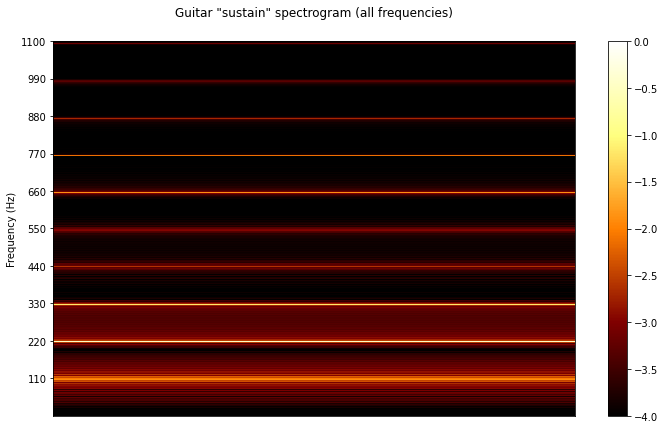

Harmonics only:


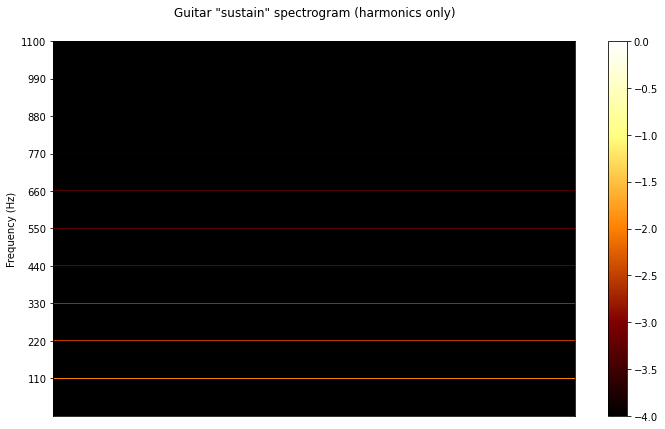

In [8]:
neighbour_radius = 4
guitar.trim_audio(start=0.5, end=3.5)

print('All frequencies:')
# Load audio and create spectrogram
guitar.audio_to_spectrogram(spec_thresh=4)
guitar.plot_spectrogram(guitar.spectrogram, 'Guitar "sustain" spectrogram (all frequencies)')
guitar.spectrogram_to_audio(guitar.spectrogram)

print('Harmonics only:')
# Create spectrogram which only contains the harmonics
guitar.filter_harmonics(neighbour_radius)
guitar.plot_spectrogram(guitar.spectrogram_harm, 'Guitar "sustain" spectrogram (harmonics only)')
guitar.spectrogram_to_audio(guitar.spectrogram_harm)

## Piano

All frequencies:


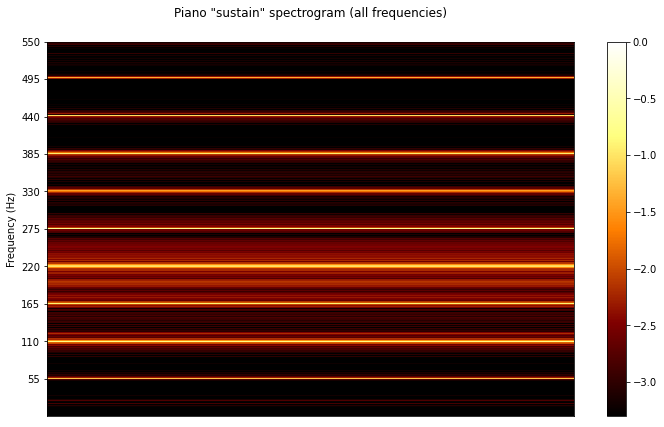

Harmonics only:


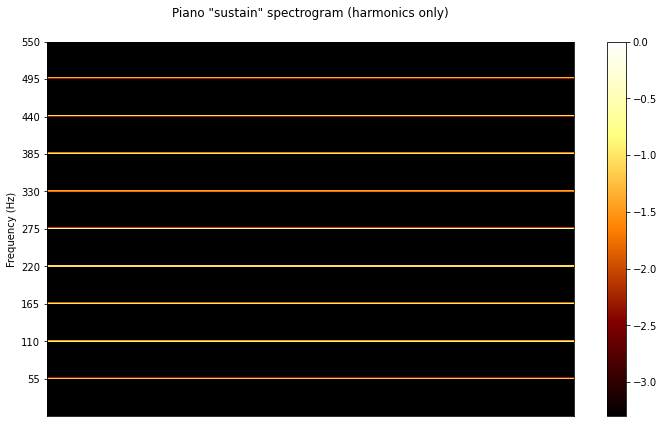

In [9]:
neighbour_radius = 4
piano.trim_audio(start=1, end=4)

print('All frequencies:')
# Load audio and create spectrogram
piano.audio_to_spectrogram(spec_thresh=3.3)
piano.plot_spectrogram(piano.spectrogram, 'Piano "sustain" spectrogram (all frequencies)')
piano.spectrogram_to_audio(piano.spectrogram)

print('Harmonics only:')
# Create spectrogram which only contains the harmonics
piano.filter_harmonics(neighbour_radius)
piano.plot_spectrogram(piano.spectrogram_harm, 'Piano "sustain" spectrogram (harmonics only)')
piano.spectrogram_to_audio(piano.spectrogram_harm)

# 4. Log scale<a id='log'></a>

## Guitar

Linear scale:


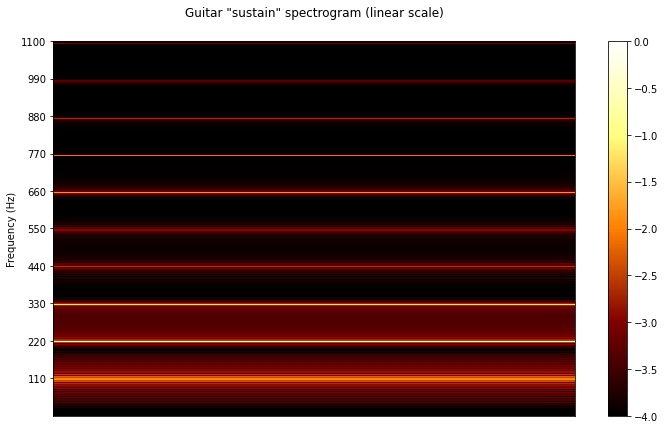

Log scale:


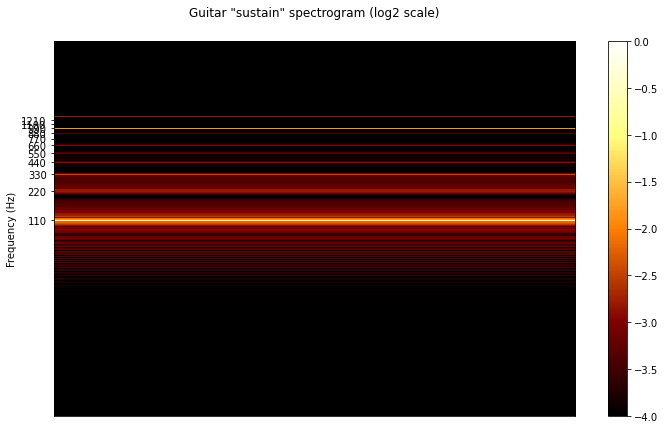

In [10]:
resolution = 16508  # guitar.calculate_log_resolution(guitar.spectrogram)
guitar.trim_audio(start=0.5, end=3.5)

print('Linear scale:')
# Load audio and create spectrogram
guitar.audio_to_spectrogram(spec_thresh=4)
guitar.plot_spectrogram(guitar.spectrogram, 'Guitar "sustain" spectrogram (linear scale)')

print('Log scale:')
# Create spectrogram on log scale
guitar.set_log_resolution(resolution)
guitar.spectrogram_to_log(guitar.spectrogram)
guitar.plot_spectrogram(guitar.spectrogram_log, 'Guitar "sustain" spectrogram (log2 scale)',
                        log_scale=True)

## Piano

Linear scale:


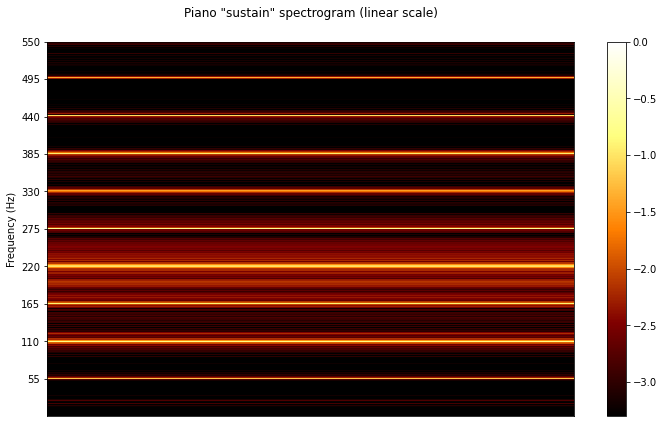

Log scale:


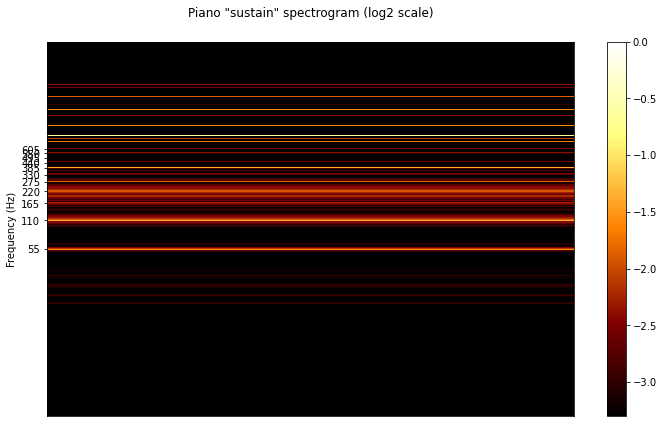

In [11]:
resolution = 16508  # piano.calculate_log_resolution(piano.spectrogram)
piano.trim_audio(start=1, end=4)

print('Linear scale:')
# Load audio and create spectrogram
piano.audio_to_spectrogram(spec_thresh=3.3)
piano.plot_spectrogram(piano.spectrogram, 'Piano "sustain" spectrogram (linear scale)')

print('Log scale:')
# Create spectrogram on log scale
piano.set_log_resolution(resolution)
piano.spectrogram_to_log(piano.spectrogram)
piano.plot_spectrogram(piano.spectrogram_log, 'Piano "sustain" spectrogram (log2 scale)',
                       log_scale=True)